# UM-Bridge with QMCPy

Using QMCPy to evaluate the [UM-Bridge Cantilever Beam Function](https://um-bridge-benchmarks.readthedocs.io/en/docs/forward-benchmarks/muq-beam-propagation.html) and approximate the expectation with respect to a uniform random variable. 

## Imports

In [33]:
import umbridge
import numpy as np
import time
import docker

#the module needs to be local if any changes have been made locally
#uncomment line below to make local qmcpy the import (only need to be done once per session and can be commented out
#import sys
#sys.path.insert(0, '../../../../..') #may need to be changed to find correct path to QMCSoftware folder

#prints paths available on local system
#for p in sys.path:
#    print(p)

#import qmcpy as qp #non local module import
from QMCSoftware import qmcpy as qp #local module import

## Start Docker Container

See the [UM-Bridge Documentation](https://um-bridge-benchmarks.readthedocs.io/en/docs/index.html) for image options. 

In [20]:
!docker run --name muqbp_new -it -d -p 4242:4242 linusseelinger/model-muq-beam:latest
#!docker run --name muqbp_new -d -p 4242:4242 my-build
#https://stackoverflow.com/questions/43099116/error-the-input-device-is-not-a-tty
#running locally

09b8dba0ca9de78cdee17d3ab0c0057b27ca0dac3d2378e2296a1abf7375a025


## Problem Setup

Initialize a QMCPy sampler and distribution.

In [21]:
sampler = qp.DigitalNetB2(dimension=31,seed=7) # DISCRETE DISTRIBUTION, default = 3
distribution = qp.Uniform(sampler,lower_bound=1,upper_bound=1.05) # TRUE MEASURE

Initialize a UM-Bridge model and wrap it into a QMCPy compatible Integrand

In [22]:
model = umbridge.HTTPModel('http://localhost:4242', 'forward')
output_dimension = 31
umbridge_config = {}
#DEBUG
print(umbridge_config)
print(model.get_input_sizes(umbridge_config))
print(model.get_output_sizes(umbridge_config))
print(distribution.d)

def lump(t):
    tnp = np.array(t[0])
    tnewnp = np.ones(output_dimension)
    tnewnp[:len(tnp)] = tnp
    return [tnewnp.tolist()]
    
integrand = qp.UMBridgeWrapper(distribution, model, umbridge_config, parallel=False, tf_input_to_umbridge_input = lump) # INTEGRAND

{}
[31]
[31]
31


## Model Evaluation

In [23]:
start_time = time.time()
x = sampler(16) # same as sampler.gen_samples(16)

print(x.shape) #prints (# of beams, input)

y = integrand.f(x)
print(y.shape) #prints (# of beams, output)
print(type(y))
print(y.dtype)
print(y)

#time in seconds
end_time = time.time()
print(end_time - start_time)

(16, 31)
(16, 31)
<class 'numpy.ndarray'>
float64
[[    0.            45.28744946   177.28452401   389.31920581
    675.25978978  1031.68613802  1452.45177877  1934.28124156
   2471.05909915  3057.50663189  3691.30912283  4368.13843853
   5082.93852311  5832.33576389  6612.96502022  7420.66136796
   8253.23034285  9106.7134449   9978.87699583 10866.34562162
  11767.08378789 12678.48452213 13598.53214184 14525.40890403
  15457.544686   16393.59835989 17332.35041153 18272.83146202
  19214.2772277  20156.15036061 21098.13060333]
 [    0.            47.77108158   184.01638612   401.77323321
    697.53399216  1064.4985957   1499.6192002   1996.26929726
   2550.82187875  3158.25137635  3813.55162783  4511.67065067
   5249.53188728  6022.39004881  6826.34714545  7659.06832178
   8516.44936452  9395.55599968 10293.18286824 11206.78844622
  12133.44286403 13071.10551243 14017.67198424 14971.21426338
  15930.02530387 16892.6979796  17857.9975933  18825.0112221
  19792.97862233 20761.36854255 217

## Automatically Approximate the Expectation

In [24]:
qmc_stop_crit = qp.CubQMCNetG(integrand,abs_tol=10) # QMC STOPPING CRITERION
#takes ~6 seconds when error tol >= 0.25, ~12 seconds at tol=0.025
solution,data = qmc_stop_crit.integrate()
print(data)

LDTransformData (AccumulateData Object)
    solution        [    0.       47.403   183.785 ... 19837.438 20807.061 21776.79 ]
    comb_bound_low  [    0.       47.393   183.746 ... 19834.606 20804.111 21773.722]
    comb_bound_high [    0.       47.413   183.824 ... 19840.269 20810.01  21779.858]
    comb_flags      [ True  True  True ...  True  True  True]
    n_total         2^(10)
    n               [1024. 1024. 1024. ... 1024. 1024. 1024.]
    time_integrate  5.816
CubQMCNetG (StoppingCriterion Object)
    abs_tol         10
    rel_tol         0
    n_init          2^(10)
    n_max           2^(35)
UMBridgeWrapper (Integrand Object)
Uniform (TrueMeasure Object)
    lower_bound     1
    upper_bound     1.050
DigitalNetB2 (DiscreteDistribution Object)
    d               31
    dvec            [ 0  1  2 ... 28 29 30]
    randomize       LMS_DS
    graycode        0
    entropy         7
    spawn_key       ()


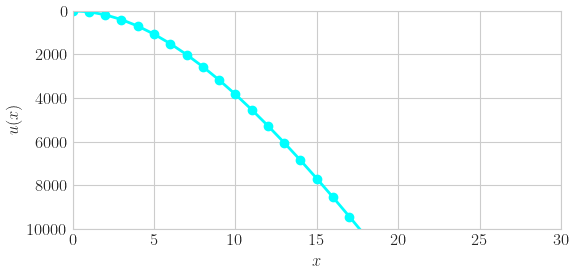

In [25]:
from matplotlib import pyplot
pyplot.style.use('../../../../qmcpy.mplstyle') #may need to be changed to find path to document in QMCSoftware folder
fig,ax = pyplot.subplots(figsize=(6,3))
ax.plot(solution,'-o')
ax.set_xlim([0,len(solution)-1]); ax.set_xlabel(r'$x$')
ax.set_ylim([10000,-10]);  ax.set_ylabel(r'$u(x)$');

## Parallel Evaluation

QMCPy can automatically multi-threaded requests to the model by setting `parallel=p` where `p` is the number of processors used by [multiprocessing.pool.ThreadPool](https://docs.python.org/3/library/multiprocessing.html#multiprocessing.pool.ThreadPool). Setting `parallel=True` is equivalent to setting `paralle=os.cpu_count()`.

In [26]:
import os
print('Available CPUs: %d'%os.cpu_count())

Available CPUs: 8


In [32]:
integrand = qp.UMBridgeWrapper(distribution,model,umbridge_config,parallel=8)
solution,data = qp.CubQMCNetG(integrand,abs_tol=10).integrate()
data

LDTransformData (AccumulateData Object)
    solution        [    0.       47.403   183.785 ... 19837.438 20807.061 21776.79 ]
    comb_bound_low  [    0.       47.393   183.746 ... 19834.606 20804.111 21773.722]
    comb_bound_high [    0.       47.413   183.824 ... 19840.269 20810.01  21779.858]
    comb_flags      [ True  True  True ...  True  True  True]
    n_total         2^(10)
    n               [1024. 1024. 1024. ... 1024. 1024. 1024.]
    time_integrate  3.276
CubQMCNetG (StoppingCriterion Object)
    abs_tol         10
    rel_tol         0
    n_init          2^(10)
    n_max           2^(35)
UMBridgeWrapper (Integrand Object)
Uniform (TrueMeasure Object)
    lower_bound     1
    upper_bound     1.050
DigitalNetB2 (DiscreteDistribution Object)
    d               31
    dvec            [ 0  1  2 ... 28 29 30]
    randomize       LMS_DS
    graycode        0
    entropy         7
    spawn_key       ()

## Shut Down Docker Image

In [ ]:
!docker rm -f muqbp_new